In [1]:
import pyBigWig
import pandas as pd
import numpy as np
import deepdish as dd
import os
import pyfaidx
import random
import pickle as pkl
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import json
import one_hot as dinuc_shuffle_main
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

In [2]:
#regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/negatives_data/negatives_with_summit.bed"
#regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/IMR90/negatives_data/negatives_with_summit.bed"
#regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/negatives_data/negatives_with_summit.bed"
regions = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/IMR90/negatives_data/negatives_with_summit.bed"

genome = "/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"
#model_h5 = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_PE/K562/nautilus_runs_may18/K562_05.13.2022_bias_128_4_1234_0.5_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
model_h5 = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/nautilus_runs/K562_02.17.2022_bias_128_4_1234_0.5_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/IMR90/nautilus_runs_apr12/IMR90_04.09.2022_bias_128_4_1234_0.8_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/IMR90/nautilus_runs_apr12/IMR90_04.09.2022_bias_128_4_1234_0.4_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5 ="/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"
#model_h5 = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/chrombpnet_model/chrombpnet_wo_bias.h5"

In [3]:
def softmax(x, temp=1):
    norm_x = x - np.mean(x,axis=1, keepdims=True)
    return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)


def get_footprint_for_motif(seqs, motif, model, inputlen, batch_size):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    w_mot_seqs = seqs.copy()
    w_mot_seqs[:, midpoint-len(motif)//2:midpoint-len(motif)//2+len(motif)] =dinuc_shuffle_main.dna_to_one_hot([motif])

    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1
    footprint_for_motif_tot = footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1]
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]

    return footprint_for_motif_tot.mean(0), counts_for_motif.mean(0)

def get_footprint_for_two_motifs(seqs, motifs, model, inputlen, batch_size, spacing):
    '''
    Returns footprints for a given motif. Motif is inserted in both the actual sequence and reverse complemented version.
    seqs input is already assumed to be one-hot encoded. motif is in sequence format.
    '''
    midpoint=inputlen//2

    spacing_per_motif = spacing // 2
    
    w_mot_seqs = seqs.copy()
    
    motif = motifs[0]
    start = midpoint-(len(motif)//2)
    w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    print(motif,start,start+len(motif))
    if spacing > 0:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start+len(motifs[0])+spacing_per_motif 
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    else:
        spacing_per_motif = spacing 
        motif = motifs[1]
        start = start + spacing_per_motif - len(motif)
        w_mot_seqs[:, start:start+len(motif)] = dinuc_shuffle_main.dna_to_one_hot([motif])
    
    print(motif,start,start+len(motif))
    
    # midpoint of motif is the midpoint of sequence
    pred_output=model.predict(w_mot_seqs, batch_size=batch_size, verbose=True)
    footprint_for_motif_fwd = softmax(pred_output[0])*(np.exp(pred_output[1])-1)

    # reverse complement the sequence
    w_mot_seqs_revc = w_mot_seqs[:, ::-1, ::-1]
    pred_output_rev=model.predict(w_mot_seqs_revc, batch_size=batch_size, verbose=True)
    footprint_for_motif_rev = softmax(pred_output_rev[0])*(np.exp(pred_output_rev[1])-1)

    # add fwd sequence predictions and reverse sesquence predictions (not we flip the rev predictions)
    counts_for_motif = np.exp(pred_output_rev[1]) - 1 + np.exp(pred_output[1]) - 1
    footprint_for_motif_tot = footprint_for_motif_fwd+footprint_for_motif_rev[:,::-1]
    footprint_for_motif =  footprint_for_motif_tot / footprint_for_motif_tot.sum(axis=1)[:, np.newaxis]

    return footprint_for_motif_tot.mean(0), counts_for_motif.mean(0)

In [4]:
def get_seq(peaks_df, genome, width, shuffle=False):
    """
    fetches sequence from a given genome.
    """
    vals = []

    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
                vals.append(sequence)

    return dinuc_shuffle_main.dna_to_one_hot(vals)

In [5]:
model=load_model(model_h5)

In [6]:
NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
inputlen = 2114
regions_df = pd.read_csv(regions, sep='\t', names=NARROWPEAK_SCHEMA)
chroms_to_keep = ["chr1"]
regions_subsample = regions_df[(regions_df["chr"].isin(chroms_to_keep))].sample(1000, random_state=0)
genome_fasta = pyfaidx.Fasta(genome)
regions_seqs = get_seq(regions_subsample, genome_fasta, inputlen)

In [7]:
motif =  ""
batch_size=128
full_footprint_control = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)

8/8 [==============================] - 4s 533ms/step


In [8]:
motif1 =  "AGGAATGT"
batch_size=128
full_footprint_control_motif1 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)

8/8 [==============================] - 4s 536ms/step


In [9]:
motif2 =  "TTGACTCA"
batch_size=128
full_footprint_control_motif2 = get_footprint_for_motif(regions_seqs, motif, model, inputlen, batch_size)

8/8 [==============================] - 4s 535ms/step


In [10]:
motifs = ["AGGAATGT","TTGACTCA"]

data_in_spacings = []
for spacing in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]:
    puu_runx_footprint = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=-1*spacing)
    data_in_spacings.append(puu_runx_footprint)

AGGAATGT 1053 1061
TTGACTCA 1044 1052
8/8 [==============================] - 4s 537ms/step
AGGAATGT 1053 1061
TTGACTCA 1043 1051
8/8 [==============================] - 4s 538ms/step
AGGAATGT 1053 1061
TTGACTCA 1042 1050
8/8 [==============================] - 4s 538ms/step
AGGAATGT 1053 1061
TTGACTCA 1041 1049
8/8 [==============================] - 4s 538ms/step
AGGAATGT 1053 1061
TTGACTCA 1040 1048
8/8 [==============================] - 4s 539ms/step
AGGAATGT 1053 1061
TTGACTCA 1039 1047
8/8 [==============================] - 4s 539ms/step
AGGAATGT 1053 1061
TTGACTCA 1038 1046
8/8 [==============================] - 4s 540ms/step
AGGAATGT 1053 1061
TTGACTCA 1037 1045
8/8 [==============================] - 4s 539ms/step
AGGAATGT 1053 1061
TTGACTCA 1036 1044
8/8 [==============================] - 4s 540ms/step
AGGAATGT 1053 1061
TTGACTCA 1035 1043
8/8 [==============================] - 4s 540ms/step
AGGAATGT 1053 1061
TTGACTCA 1034 1042
8/8 [==============================] - 4s 540ms/step

In [11]:
motifs = ["AGGAATGT","TTGACTCA"]

data_in_spacings_rev = []
for spacing in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]:
    puu_runx_footprint = get_footprint_for_two_motifs(regions_seqs, motifs, model, inputlen, batch_size, spacing=spacing)
    data_in_spacings_rev.append(puu_runx_footprint)

AGGAATGT 1053 1061
TTGACTCA 1062 1070
8/8 [==============================] - 4s 541ms/step
AGGAATGT 1053 1061
TTGACTCA 1063 1071
8/8 [==============================] - 4s 540ms/step
AGGAATGT 1053 1061
TTGACTCA 1064 1072
8/8 [==============================] - 4s 540ms/step
AGGAATGT 1053 1061
TTGACTCA 1065 1073
8/8 [==============================] - 4s 541ms/step
AGGAATGT 1053 1061
TTGACTCA 1066 1074
8/8 [==============================] - 4s 540ms/step
AGGAATGT 1053 1061
TTGACTCA 1067 1075
8/8 [==============================] - 4s 540ms/step
AGGAATGT 1053 1061
TTGACTCA 1068 1076
8/8 [==============================] - 4s 540ms/step
AGGAATGT 1053 1061
TTGACTCA 1069 1077
8/8 [==============================] - 4s 541ms/step
AGGAATGT 1053 1061
TTGACTCA 1070 1078
8/8 [==============================] - 4s 541ms/step
AGGAATGT 1053 1061
TTGACTCA 1071 1079
8/8 [==============================] - 4s 540ms/step
AGGAATGT 1053 1061
TTGACTCA 1072 1080
8/8 [==============================] - 4s 540ms/step

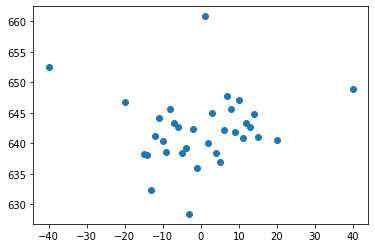

In [12]:
all_counts = [x[1] for x in data_in_spacings]
all_counts_rev = [x[1] for x in data_in_spacings_rev]


plt.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40],all_counts_rev+all_counts)


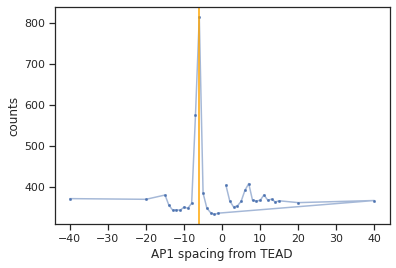

In [11]:

from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("ticks", {'axes.grid' : False})

plt.scatter([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40],all_counts_rev[0:]+all_counts[0:], linewidths=0.5, edgecolors=None,s=5)
plt.plot([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40]+[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40],all_counts_rev[0:]+all_counts[0:], alpha=0.5 )

# Dataset
x = np.array([-1,-2,-3,-4,-5,-6,-7,-8,-9,-10,-11,-12,-13,-14,-15,-20,-40][::-1]+[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,40])
y = np.array(all_counts[::-1]+all_counts_rev)

X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
#Y_ = X_Y_Spline(X_)

plt.axvline(-6, color="orange", linestyle="-")  #vertical line
#plt.plot(X_,Y_)
plt.ylabel("counts")
plt.xlabel("AP1 spacing from TEAD")

plt.savefig("subfigs/ap1_tead_syntax_dnase.pdf", transparent=True, dpi=300)

